> #### We try to learn the filter-back projection in a "denoising" way. For this, we implement a denoising autoencoder Neural Network architecture that learns the filter-back projection line by line.
> #### In other words, we then try to counter the blurring effect implied by a learned projection using a denoiser autoencoder.
> #### For each angle, we implement an autoencoder. Stacking these autoencoders together provides a general Neural Network architecture we call the SinoNet.
> #### Warning : to reproduce more precisely what happens with a true DBT, one must take in account that only a limited range of projections angle is possible to obtain.

> Schéma : 
<img src="talbonet.png",width=500, height=500>

# Packages Loading

In [145]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense, Input
from keras.layers import Activation, UpSampling2D, BatchNormalization, Reshape
from keras.models import Sequential, Input, Model
from keras.utils.np_utils import to_categorical
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from keras import backend as K
from keras import optimizers
%matplotlib inline
import numpy as np
import tensorflow as tf
config = tf.ConfigProto( device_count = {'GPU': 1 , 'CPU': 56} ) 
sess = tf.Session(config=config) 
keras.backend.set_session(sess)
import cv2

# Data Loading

### Projection matrix

In [146]:
import scipy.io
mat = scipy.io.loadmat('thinL64_90.mat')
A = mat['H'].todense()

### Training Data

In [152]:
import h5py
brains = []
N = int(0.8*767)
for i in range(1, 767):
    with  h5py.File('brains-master/%s.mat' %i, 'r') as f:
        brain = np.array(f['cjdata']['image'])
        brain = brain[::8, ::8]
        brains += [brain]

brains = np.array(brains)
brains_train = np.array(brains)[0:N-1]
print(brains_train.shape)

(612, 64, 64)


In [148]:
# proper rotation function
def rotate_bound(image, angle):
    # grab the dimensions of the image and then determine the
    # center
    (h, w) = image.shape[:2]
    (cX, cY) = (w // 2, h // 2)
 
    # grab the rotation matrix (applying the negative of the
    # angle to rotate clockwise), then grab the sine and cosine
    # (i.e., the rotation components of the matrix)
    M = cv2.getRotationMatrix2D((cX, cY), -angle, 1.0)
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])
 
    # compute the new bounding dimensions of the image
    nW = int((h * sin) + (w * cos))
    nH = int((h * cos) + (w * sin))
 
    # adjust the rotation matrix to take into account translation
    M[0, 2] += (nW / 2) - cX
    M[1, 2] += (nH / 2) - cY
 
    # perform the actual rotation and return the image
    return cv2.warpAffine(image, M, (nW, nH))

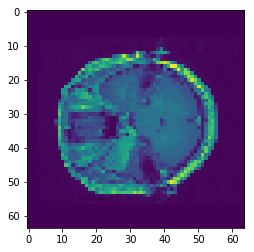

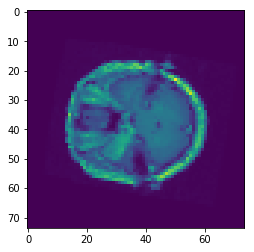

In [149]:
rot_img = rotate_bound(brains[0], 10)
plt.figure(1)
plt.imshow(brains[0])
plt.show()
plt.figure(1)
plt.imshow(rot_img)
plt.show()

In [150]:
brains_10_train = np.array([rotate_bound(brains_train[i], 10) for i in range(N-1)])

### Projections Data

In [154]:
projections = []
for i in range(brains.shape[0]):
    p = np.matmul(A, brains[i].flatten())
    p = p.reshape((90,90))
    projections += [p]

projections = np.array(projections)
projections_train = np.array(projections)[0:N-1]
print(projections_train.shape)

(612, 90, 90)


### Vizualisations

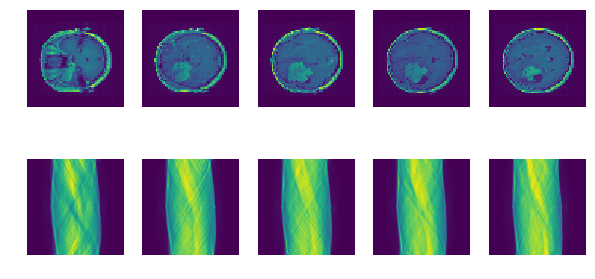

In [155]:
fig=plt.figure(figsize=(10, 5))

for i in range(5):
    idx = np.random.randint(766)
    fig.add_subplot(2, 5, i+1)
    plt.imshow(brains[i])
    plt.axis('off')
    fig.add_subplot(2, 5, i+6)
    plt.imshow(projections[i])
    plt.axis('off')

In [156]:
projections[0].shape

(90, 90)

In [158]:
alpha = 10 #a certain angle of projection (the real tomography for cancer uses a limited range of angle)
outputs_train = []
for i in range(brains_train.shape[0]):
    outputs_train.append(projections_train[i,:,alpha])
outputs_train = np.array(outputs_train)

In [159]:
outputs_train[0]

array([  0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
        34.12320043,  95.25596386, 141.88577048, 175.78454529,
       207.52938119, 245.05512159, 271.41737893, 280.85656656,
       294.40675062, 309.12749826, 323.6440572 , 338.46194178,
       351.56006373, 359.31255646, 367.93828265, 375.09984149,
       377.87533698, 376.95779014, 375.31428394, 373.56874271,
       373.37664441, 367.4279905 , 341.1262019 , 301.93512533,
       270.99392839, 245.65296789, 189.92981602, 101.90012818,
         8.15742029,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   3.79101735,  57.80631738,
       132.07963803, 186.62412216, 227.50846361, 272.02561262,
       317.38552127, 339.05411922, 331.47222316, 319.24025259,
       316.89732943, 316.09767113, 313.73616875, 311.20

# Decoupled Encoder-Decoder Training

In [58]:
X_train_encoder = brains_train
Y_train_encoder = outputs_train
X_train_encoder = X_train_encoder.reshape(X_train.shape_encoder[0], 64, 64, 1)
Y_train_encoder = Y_train_encoder.reshape(Y_train_encoder.shape[0], 90, 1)

In [59]:
X_train_encoder = X_train_encoder/np.max(X_train_encoder)
Y_train_encoder = Y_train_encoder/np.max(Y_train_encoder)

In [160]:
model_encoder = Sequential()
model_encoder.add(Conv2D(16, (3, 3), activation='relu',input_shape=(64,64,1),padding='same',strides=(1,1),data_format = "channels_last"))
model_encoder.add(Conv2D(16, (3, 3), activation='relu',input_shape=(64,64,1),padding='same',strides=(1,1),data_format = "channels_last"))
#model.add(BatchNormalization())
model_encoder.add(MaxPooling2D((2, 2), padding='same'))
model_encoder.add(Conv2D(32, (3, 3), activation='relu',input_shape=(64,64,1),padding='same',strides=(1,1),data_format = "channels_last"))
model_encoder.add(Conv2D(32, (3, 3), activation='relu',input_shape=(64,64,1),padding='same',strides=(1,1),data_format = "channels_last"))
#model.add(BatchNormalization())
model_encoder.add(MaxPooling2D((2, 2), padding='same'))
model_encoder.add(Conv2D(64, (3, 3), activation='relu',input_shape=(64,64,1),padding='same',strides=(1,1),data_format = "channels_last"))
model_encoder.add(Conv2D(64, (3, 3), activation='relu',input_shape=(64,64,1),padding='same',strides=(1,1),data_format = "channels_last"))
#model.add(BatchNormalization())
model_encoder.add(MaxPooling2D((2, 2), padding='same'))
model_encoder.add(Flatten())
model_encoder.add(Dense(90))
adam = optimizers.Adam(lr=0.001)
model_encoder.compile(loss='binary_crossentropy',optimizer=adam)
model_encoder.summary()
model_encoder.fit(X_train,Y_train,batch_size=32,epochs=100, verbose=1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_305 (Conv2D)          (None, 64, 64, 16)        160       
_________________________________________________________________
conv2d_306 (Conv2D)          (None, 64, 64, 16)        2320      
_________________________________________________________________
max_pooling2d_43 (MaxPooling (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_307 (Conv2D)          (None, 32, 32, 32)        4640      
_________________________________________________________________
conv2d_308 (Conv2D)          (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_44 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_309 (Conv2D)          (None, 16, 16, 64)        18496     
__________

766/766 [==============================] - 9s - loss: 0.1586     
Epoch 83/100
766/766 [==============================] - 9s - loss: 0.1586     
Epoch 84/100
766/766 [==============================] - 9s - loss: 0.1585     
Epoch 85/100
766/766 [==============================] - 9s - loss: 0.1585     
Epoch 86/100
766/766 [==============================] - 9s - loss: 0.1585     
Epoch 87/100
766/766 [==============================] - 10s - loss: 0.1586    
Epoch 88/100
766/766 [==============================] - 9s - loss: 0.1588     
Epoch 89/100
766/766 [==============================] - 9s - loss: 0.1593     
Epoch 90/100
766/766 [==============================] - 10s - loss: 0.1591    
Epoch 91/100
766/766 [==============================] - 11s - loss: 0.1588    
Epoch 92/100
766/766 [==============================] - 10s - loss: 0.1592    
Epoch 93/100
766/766 [==============================] - 10s - loss: 0.1607    
Epoch 94/100
766/766 [==============================] - 9s - loss

In [162]:
X_train_decoder = model_encoder.predict(brains_train.reshape(brains_train.shape[0], 64, 64, 1))
Y_train_decoder = brains_train
X_train_decoder = X_train_decoder.reshape(X_train_decoder.shape[0], 90)
Y_train_decoder = Y_train_decoder.reshape(Y_train_decoder.shape[0], 64, 64, 1)
X_train_decoder = X_train_decoder/np.max(X_train_decoder)
Y_train_decoder = Y_train_decoder/np.max(Y_train_decoder)

In [163]:
model_decoder = Sequential()
model_decoder.add(Dense(64, input_shape = (90,)))
model_decoder.add(Reshape((8, 8, 1)))
model_decoder.add(UpSampling2D((2, 2)))
model_decoder.add(Conv2D(64, (3, 3), activation='relu',input_shape=(90,90,1),padding='same',strides=(1,1),data_format = "channels_last"))
model_decoder.add(Conv2D(64, (3, 3), activation='relu',input_shape=(90,90,1),padding='same',strides=(1,1),data_format = "channels_last"))
#model.add(BatchNormalization())
model_decoder.add(UpSampling2D((2, 2)))
model_decoder.add(Conv2D(32, (3, 3), activation='relu',input_shape=(90,90,1),padding='same',strides=(1,1),data_format = "channels_last"))
model_decoder.add(Conv2D(32, (3, 3), activation='relu',input_shape=(90,90,1),padding='same',strides=(1,1),data_format = "channels_last"))
#model.add(BatchNormalization())
model_decoder.add(UpSampling2D((2, 2)))
model_decoder.add(Conv2D(16, (3, 3), activation='relu',input_shape=(90,90,1),padding='same',strides=(1,1),data_format = "channels_last"))
model_decoder.add(Conv2D(1, (3, 3), activation='relu',input_shape=(90,90,1),padding='same',strides=(1,1),data_format = "channels_last"))
adam = optimizers.Adam(lr=0.001)
model_decoder.compile(loss='binary_crossentropy',optimizer=adam)
model_decoder.summary()
model_decoder.fit(X_train_decoder,Y_train_decoder,batch_size=32,epochs=100, verbose=1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_56 (Dense)             (None, 64)                5824      
_________________________________________________________________
reshape_47 (Reshape)         (None, 8, 8, 1)           0         
_________________________________________________________________
up_sampling2d_119 (UpSamplin (None, 16, 16, 1)         0         
_________________________________________________________________
conv2d_311 (Conv2D)          (None, 16, 16, 64)        640       
_________________________________________________________________
conv2d_312 (Conv2D)          (None, 16, 16, 64)        36928     
_________________________________________________________________
up_sampling2d_120 (UpSamplin (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_313 (Conv2D)          (None, 32, 32, 32)        18464     
__________

612/612 [==============================] - 14s - loss: 0.2333    
Epoch 83/100
612/612 [==============================] - 15s - loss: 0.2330    
Epoch 84/100
612/612 [==============================] - 14s - loss: 0.2327    
Epoch 85/100
612/612 [==============================] - 14s - loss: 0.2331    
Epoch 86/100
612/612 [==============================] - 14s - loss: 0.2329    
Epoch 87/100
612/612 [==============================] - 14s - loss: 0.2327    
Epoch 88/100
612/612 [==============================] - 14s - loss: 0.2329    
Epoch 89/100
612/612 [==============================] - 16s - loss: 0.2326    
Epoch 90/100
612/612 [==============================] - 17s - loss: 0.2328    
Epoch 91/100
612/612 [==============================] - 16s - loss: 0.2327    
Epoch 92/100
612/612 [==============================] - 15s - loss: 0.2325    
Epoch 93/100
612/612 [==============================] - 14s - loss: 0.2323    
Epoch 94/100
612/612 [==============================] - 14s - los

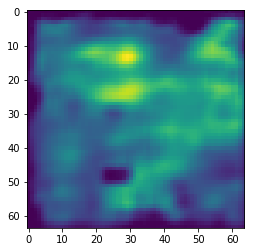

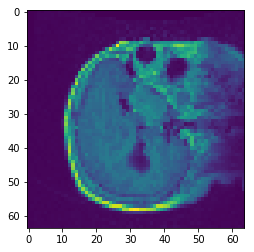

In [182]:
test_1 = model_decoder.predict(projections[N+10,:,10].reshape(1,90))
plt.figure(1)
plt.imshow(test_1[0,:,:,0])
plt.show()
plt.figure(1)
plt.imshow(brains[N+10])
plt.show()

# Coupled Encoder-Decoder Training